In [135]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [136]:
def load_data(type, file_type):
    path = f"dataset/{type}/{file_type}.csv"
    df = pd.read_csv(
        path, 
        encoding="utf-8",
        low_memory=False,
        dtype=int)
    
    df["label"] = 1 if file_type == "A1" else 0
    return df

In [137]:
train_dfs_A1 = load_data("train", "A1")
train_dfs_A2 = load_data("train", "A2")

df_train = pd.concat([train_dfs_A1, train_dfs_A2], ignore_index=True)

df_a1_test = load_data("test", "A1")
df_a2_test = load_data("test", "A2")

# Combine into one DataFrame for testing
df_test = pd.concat([df_a1_test, df_a2_test], ignore_index=True)

# shuffle
df_train = df_train.sample(frac=1, random_state=42)
df_test = df_test.sample(frac=1, random_state=42)

cols = [col for col in df_train.columns if (col != '發生日期' and col != "label")]

df_train = df_train.dropna(how='any')
df_test = df_test.dropna(how='any')

X_train = df_train[cols]
y_train = df_train["label"]

X_test = df_test[cols]
y_test = df_test["label"]

In [138]:
# Print original class distribution
print("Original distribution:", Counter(y_train))

# Oversample the training data
ros = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = ros.fit_resample(X_train, y_train)
X_test, y_test = ros.fit_resample(X_test, y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the new class distribution
print("Resampled distribution:", Counter(y_train))


Original distribution: Counter({0: 1108672, 1: 7279})
Resampled distribution: Counter({0: 1108672, 1: 1108672})


In [139]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert probabilities to binary predictions
        y_pred = tf.cast(tf.greater(y_pred, self.threshold), tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [140]:
# ------------------------------------------------
# Build a TensorFlow Model
# ------------------------------------------------

model = tf.keras.Sequential([
    # Input layer
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # First hidden layer with 128 units
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Second hidden layer with 64 units
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Third hidden layer with 32 units
    layers.Dense(32, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Fourth hidden layer with 16 units
    layers.Dense(16, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Output layer for binary classification
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        # "Accuracy"
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        F1Score(name='f1_score'),
        tf.keras.metrics.AUC(name='auc', num_thresholds=200)
    ]
)

# ------------------------------------------------
# Train Model
# ------------------------------------------------

history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=2048,
    validation_split=0.3,
    verbose=1
)

# ------------------------------------------------
# Evaluate on Test Data from 109 files
# ------------------------------------------------
pred_probs = model.predict(X_test).ravel()
pred_labels = (pred_probs > 0.5).astype(int)

precision = precision_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

print("Precision:", precision)
print("Recall:   ", recall)
print("F1 Score: ", f1)

# Optional: detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, pred_labels, target_names=["A2 (Injury)", "A1 (Fatal)"]))


/home/luluboy/SynologyDrive/School/大三下/人工智慧總整實作/Project1/ubuntu_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/80
758/758 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6904 - auc: 0.7327 - f1_score: 0.5351 - loss: 0.5837 - precision: 0.4819 - recall: 0.6142 - val_accuracy: 0.5913 - val_auc: 0.0000e+00 - val_f1_score: 0.7432 - val_loss: 0.8152 - val_precision: 1.0000 - val_recall: 0.5913
Epoch 2/80
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7853 - auc: 0.8262 - f1_score: 0.5886 - loss: 0.4521 - precision: 0.6513 - recall: 0.5369 - val_accuracy: 0.5555 - val_auc: 0.0000e+00 - val_f1_score: 0.7142 - val_loss: 0.8269 - val_precision: 1.0000 - val_recall: 0.5555
Epoch 3/80
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7914 - auc: 0.8363 - f1_score: 0.5967 - loss: 0.4402 - precision: 0.6667 - recall: 0.5401 - val_accuracy: 0.5692 - val_auc: 0.0000e+00 - val_f1_score: 0.7255 - val_loss: 0.8080 - val_precision: 1.0000 - val_recall: 0.5692
Epoch 4/80
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7957 - auc: 0.8434 - f1_score: 0.6038 - loss: 0.4317 - precision: 0.

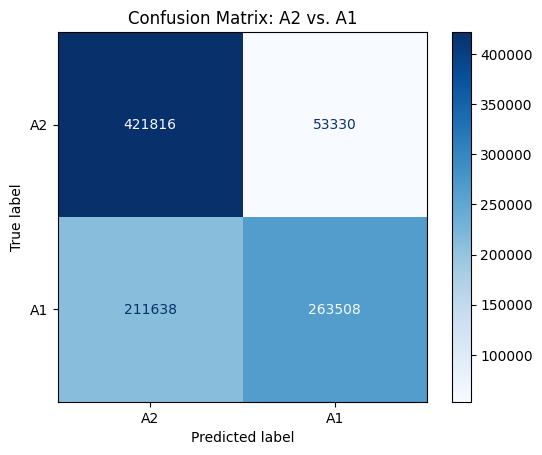

In [141]:
# 1. Compute the confusion matrix
cm = confusion_matrix(y_test, pred_labels)

# 2. Create a display object,  passing in class names label=0 -> A2, label=1 -> A1
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["A2", "A1"])

# 3. Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: A2 vs. A1")
plt.show()

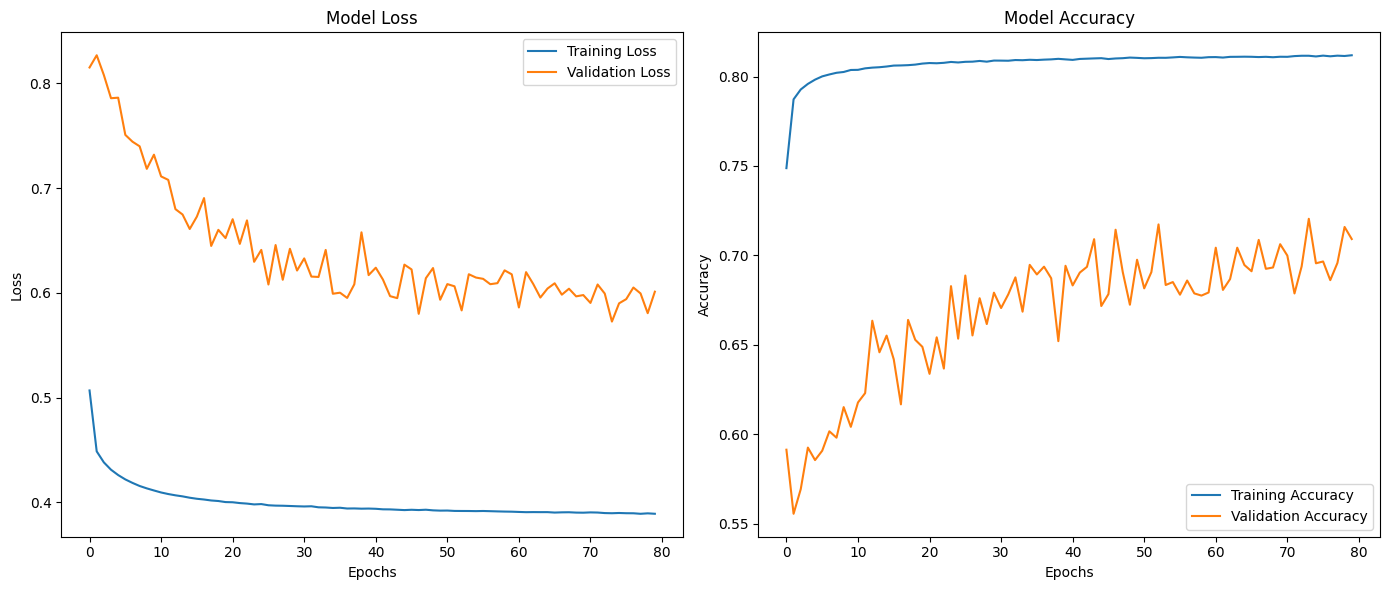

In [142]:
# Plotting loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

# Plotting accuracy (ensure you have added an accuracy metric in model.compile)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
else:
    print("Accuracy metric not found. Consider adding tf.keras.metrics.BinaryAccuracy(name='accuracy') to model.compile.")

plt.tight_layout()
plt.show()


In [143]:
print(y_test.shape)

(950292,)
